In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv("/content/sample_data/used_device_data.csv")

In [ ]:
columns_with_yes_no = ['4g', '5g']
df[columns_with_yes_no] = df[columns_with_yes_no].replace({"yes": 1, "no": 0})
df = df.infer_objects(copy=False)
df_processed = pd.get_dummies(df)

<ipython-input-3-59d2422213f9>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_with_yes_no] = df[columns_with_yes_no].replace({"yes": 1, "no": 0})


In [ ]:
df_processed.head()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,...,device_brand_Sony,device_brand_Spice,device_brand_Vivo,device_brand_XOLO,device_brand_Xiaomi,device_brand_ZTE,os_Android,os_Others,os_Windows,os_iOS
0,14.50,1,0,13.0,5.0,64.0,3.0,3020.0,146.0,2020,...,False,False,False,False,False,False,True,False,False,False
1,17.30,1,1,13.0,16.0,128.0,8.0,4300.0,213.0,2020,...,False,False,False,False,False,False,True,False,False,False
2,16.69,1,1,13.0,8.0,128.0,8.0,4200.0,213.0,2020,...,False,False,False,False,False,False,True,False,False,False
3,25.50,1,1,13.0,8.0,64.0,6.0,7250.0,480.0,2020,...,False,False,False,False,False,False,True,False,False,False
4,15.32,1,0,13.0,8.0,64.0,3.0,5000.0,185.0,2020,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
rows_with_nan_count = df_processed.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {rows_with_nan_count}")
df_processed = df_processed.fillna(df_processed.median())
rows_with_nan_count_after_processing = df_processed.isna().any(axis=1).sum()
print(f"Number of rows with NaN values after processing: {rows_with_nan_count_after_processing}")


Number of rows with NaN values: 201
Number of rows with NaN values after processing: 0


In [ ]:
df_processed.describe()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000,3454.000000
mean,13.713115,0.676028,0.044007,9.384534,6.553329,54.546957,4.036080,3133.170961,182.705761,2015.965258,674.869716,4.364712,5.233107
std,3.805280,0.468057,0.205140,4.700148,6.968453,84.926611,1.364314,1298.565062,88.329494,2.298455,248.580166,0.588914,0.683637
min,5.080000,0.000000,0.000000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,0.000000,0.000000,5.000000,2.000000,16.000000,4.000000,2100.000000,142.000000,2014.000000,533.500000,4.033931,4.790342
50%,12.830000,1.000000,0.000000,8.000000,5.000000,32.000000,4.000000,3000.000000,160.000000,2015.500000,690.500000,4.405133,5.245892
75%,15.340000,1.000000,0.000000,13.000000,8.000000,64.000000,4.000000,4000.000000,185.000000,2018.000000,868.750000,4.755700,5.673718
max,30.710000,1.000000,1.000000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


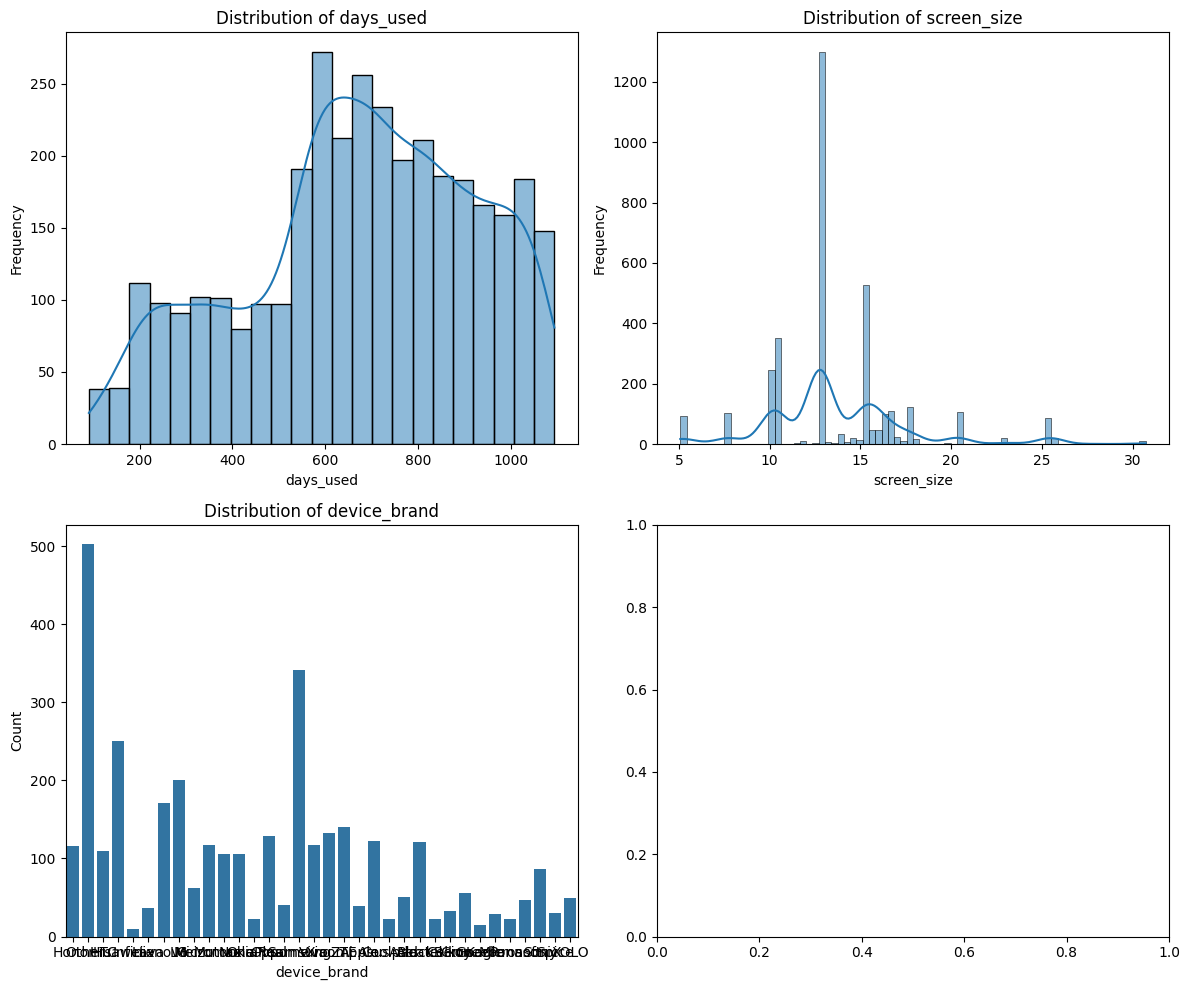

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

list1 = ['days_used', 'screen_size', 'device_brand']

# Set up the plot grid for 2x2 (2 rows, 2 columns)
num_cols = 2
num_rows = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, col in enumerate(list1):
    ax = axes[i]  # Get the appropriate subplot axis

    if df[col].dtype in ['int64', 'float64']:  # Numeric columns
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    else:  # Categorical columns
        sns.countplot(x=col, data=df, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import pearsonr

# Calculate correlations and p-values
correlations = []
p_values = []

for col in df_processed.columns:
    if col != "days_used":
        corr, p_val = pearsonr(df_processed[col], df_processed["days_used"])
        correlations.append(corr)
        p_values.append(p_val)

# Create a DataFrame to store results
dtf_corr = pd.DataFrame({
    "Correlation": correlations,
    "P-value": p_values
}, index=df_processed.columns.drop("days_used"))
stars = []
for col in df_processed.columns:
    if col != "days_used":
        corr, p_val = pearsonr(df_processed[col], df_processed["days_used"])
        correlations.append(corr)
        p_values.append(p_val)

        # Add '*' if p-value is less than 0.05
        if p_val < 0.05:
            stars.append('*')
        else:
            stars.append('')

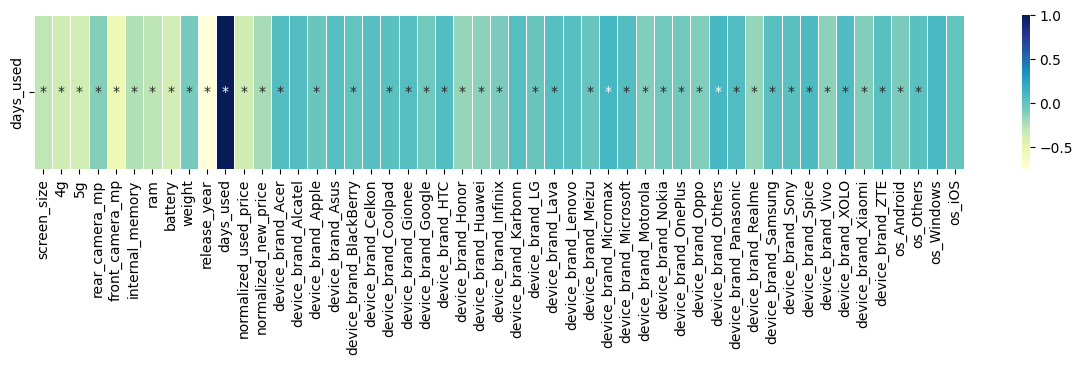

In [ ]:
dtf_corr = df_processed.corr(method="pearson").loc[["days_used"]]

# Create a list of annotations with stars
annot = []
for i, corr in enumerate(dtf_corr.iloc[0]):
    star = stars[i] if i < len(stars) else ''
    annot.append(f'{star}')

# Plot the heatmap with annotations
fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(dtf_corr, annot=[annot], fmt='', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)

plt.show()

Explain about drop - high negative correlation

In [ ]:
df_processed = df_processed.drop(columns=["release_year"])

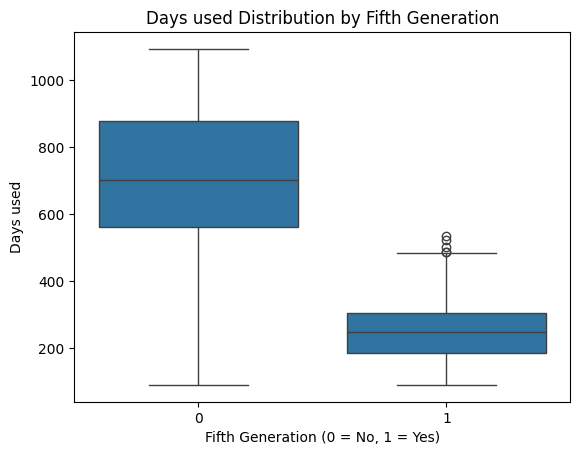

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='5g', y='days_used', data=df_processed)
plt.title('Days used Distribution by Fifth Generation')
plt.xlabel('Fifth Generation (0 = No, 1 = Yes)')
plt.ylabel('Days used')
plt.show()


<ipython-input-12-ee6a3a51a7e7>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_processed[df_processed['5g'] == 1]['days_used'], label='5g', shade=True, color='red')
<ipython-input-12-ee6a3a51a7e7>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_processed[df_processed['5g'] == 0]['days_used'], label='No 5g', shade=True, color='blue')


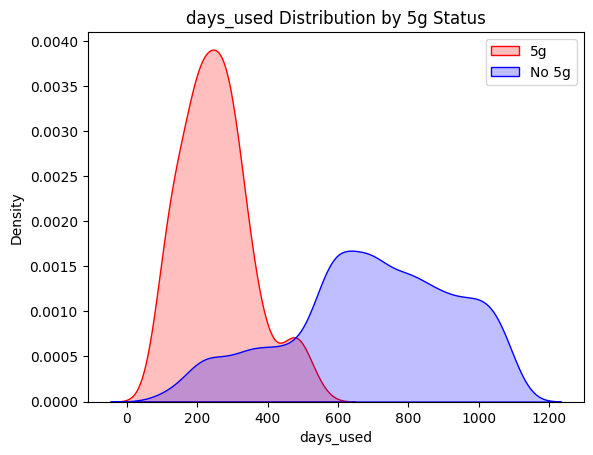

In [ ]:
sns.kdeplot(df_processed[df_processed['5g'] == 1]['days_used'], label='5g', shade=True, color='red')
sns.kdeplot(df_processed[df_processed['5g'] == 0]['days_used'], label='No 5g', shade=True, color='blue')
plt.title('days_used Distribution by 5g Status')
plt.xlabel('days_used')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
sns.countplot(x='MemoryComplaints', hue='Diagnosis', data=df_processed)
plt.title('Pain when exercise vs Heart Disease')
plt.xlabel('Pain when exercise (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()

ValueError: Could not interpret value `MemoryComplaints` for `x`. An entry with this name does not appear in `data`.

In [ ]:
sns.countplot(x='EducationLevel', hue='Diagnosis', data=df_basic)
plt.title('Chest Pain Type Distribution by Heart Disease')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Heart Disease', loc='upper right', labels=['No', 'Yes'])
plt.show()

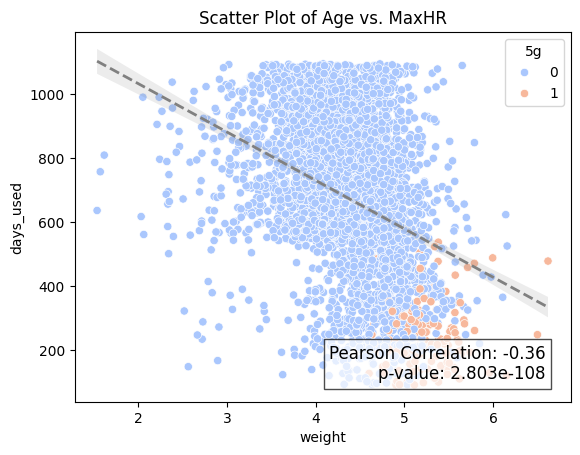

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot with color-coded target variable
sns.scatterplot(x='normalized_used_price', y='days_used', hue='5g', palette='coolwarm', data=df_processed)

# Add regression line for trend analysis (optional)
sns.regplot(x='normalized_used_price', y='days_used', data=df_processed, scatter=False, color='gray', line_kws={'lw': 2, 'ls': '--'})

# Show Pearson correlation coefficient on the plot
# Compute the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(df_processed['days_used'], df_processed['5g'])

# Show Pearson correlation and p-value on the plot in the bottom-right corner
plt.text(0.95, 0.05, f'Pearson Correlation: {correlation:.2f}\np-value: {p_value:.3e}',
         transform=plt.gca().transAxes, fontsize=12, color='black',
         ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


# Title and labels
plt.title('Scatter Plot of Age vs. MaxHR')
plt.xlabel('weight')
plt.ylabel('days_used')
plt.legend(title='5g', loc='upper right')

# Show plot
plt.show()


Linear Regression - MSE: 33250.3158, MAE: 150.1417, R²: 0.4788
XGBoost - MSE: 28194.1128, MAE: 137.5022, R²: 0.5580


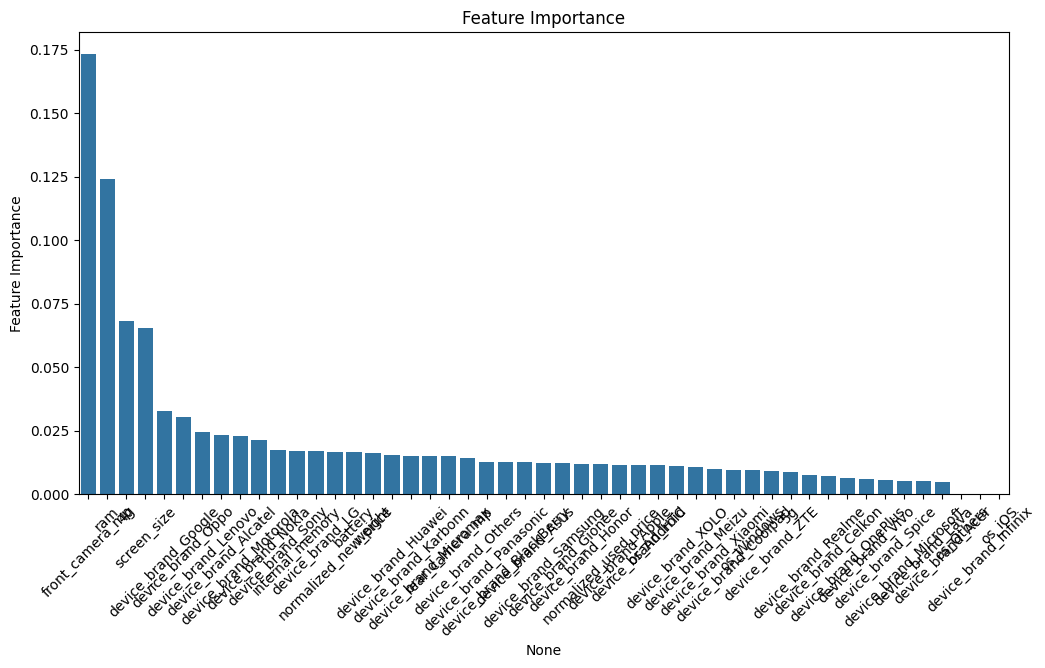

In [ ]:

X = df_processed.drop(columns=["days_used"])
y = df_processed["days_used"]


X = X.fillna(X.median())
y = y.fillna(y.median())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr:.4f}, MAE: {mae_lr:.4f}, R²: {r2_lr:.4f}")

xgb = XGBRegressor()

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}")

feats = pd.DataFrame(index=X.columns, data=xgb.feature_importances_, columns=["Feature Importance"])
XGB_feature_imp = feats.sort_values("Feature Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=XGB_feature_imp["Feature Importance"], x=XGB_feature_imp.index)
plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

